# Number Partitioning using QAOA

## Number partitioning problem
Number partitioning - also referred to as the number bi-partitioning problem, or the 2-partition problem - is one of Karp’s original NP-hard problems, and can be stated as follows. We have a set S of n numbers, and the goal of the optimisation problem is separate them into two disjoint subsets S1 and S2 such that the difference of the sums of the two subsets is minimised.

We want to minimize $|\sum_is_ix_i^z|$ so we can set our cost function to be:
$$f=(\sum_is_ix_i)^2 = \sum_{i<j} 2s_is_jx_ix_j +\sum_is_i^2x_i^2\quad, x\in\{1,-1\}^n$$ where the second term is a constant and we only need to minimize the first term. We can construct a Hamiltonian
$$H = \sum_{i< j} 2s_is_jx_i^zx_j^z\quad, x^z_i=\text{PauliZ}$$

The unitarty gate in QAOA circuit should be:
$$U_C=e^{-iH\gamma} =e^{-i2\gamma\sum_{i< j} s_is_jx_i^zx_j^z} $$
for each pair of qubits $(i,j)$ the unitary gates would be:

$$e^{-i2\gamma s_is_jx_i^zx_j^z} = \text{CNOT}(i,j)R_z^j(-4\gamma s_is_j)\text{CNOT}(i,j)$$

At the same time the mixer in QAOA circuit should be:
$$U_B=e^{-i\beta\sum_i\sigma_i^x}$$

In [76]:
%matplotlib inline

#import myQAOA package
from myQAOA import partitionQAOA

import qiskit
import numpy as np

from qiskit import Aer
from qiskit import QuantumRegister, QuantumCircuit, execute

from scipy.optimize import  minimize
from numpy import pi
from qiskit.visualization import plot_histogram

from qiskit.optimization.applications.ising.common import (read_numbers_from_file,
                                                           random_number_list, sample_most_likely)


from qiskit.aqua import QuantumInstance
from qiskit.optimization.applications.ising import partition
from qiskit.aqua.algorithms import QAOA, NumPyMinimumEigensolver
from qiskit.aqua.components.optimizers import COBYLA


In [77]:
#generating an instance

#read the number list from file
number_list = read_numbers_from_file('sample.partition')
print("We will do number partitioning on this set:", number_list)

We will do number partitioning on this set: [4 5 6 7 8]


In [78]:
# initial an QAOA algortihm for number partitioning
myqaoa = partitionQAOA(number_list, layer=1)

Let's take a look of the quantum circuit: (assume parameters $\gamma = 1, \beta = 1$)

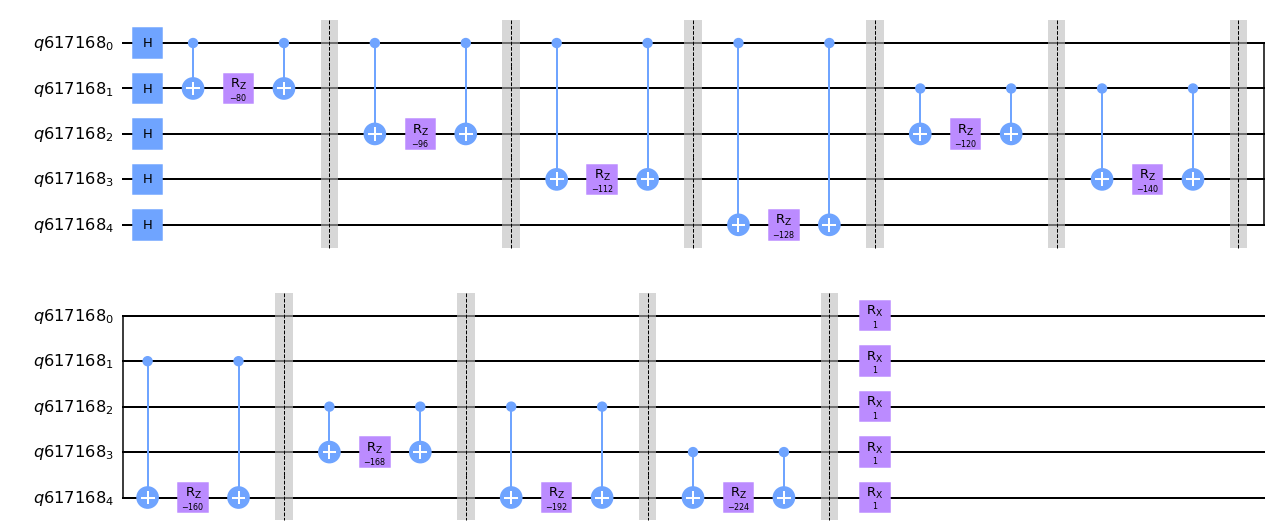

In [79]:
myqaoa.QAOAcircuit(np.array([1,1])).draw('mpl')

Now we can do optimization to minimize the expectation value.

In [80]:
result = myqaoa.optimization_output()

Take the optimal parameters and evalute the final circuit

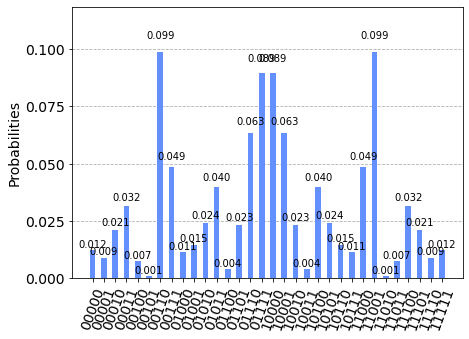

In [81]:
optimal_para = result.x
optimal_circuit = myqaoa.QAOAcircuit(optimal_para)
final_distribution = execute(optimal_circuit, Aer.get_backend("statevector_simulator"),
                                     shots=1000).result().get_counts()
plot_histogram(final_distribution)

In QAOA, we take the most probable output as our result:

In [82]:
partition_result = sample_most_likely(final_distribution)[::-1]
print("the problem set is:", number_list)
print("solution          :", partition_result)
print("the difference between 2 sets should be:", abs(np.sum(list(map(lambda x:pow(-1,x),partition_result))*number_list)))

the problem set is: [4 5 6 7 8]
solution          : [1 1 0 0 1]
the difference between 2 sets should be: 4


## Run the QAOA for 100 times

Here we will use the classical algorithm ```NumPyMinimumEigensolver``` to get the correct result.

In [83]:
qubitOp, offset = partition.get_operator(number_list)
result = NumPyMinimumEigensolver(qubitOp).run()

classical_result = sample_most_likely(result.eigenstate)
print('energy:', result.eigenvalue.real)
print('partition objective:', result.eigenvalue.real + offset)
print('solution objective:', partition.partition_value(classical_result, number_list))
classical_optimal = 0
classical_optimal = np.vstack([classical_result,(classical_result +1)%2])
print('Two possible solutions:', classical_optimal)

energy: -190.0
partition objective: 0.0
solution objective: 0
Two possible solutions: [[0 0 0 1 1]
 [1 1 1 0 0]]


In [84]:
def result_process(myqaoa, n_loops):
    count = 0
    for _ in range(n_loops):
        para = myqaoa.optimization_output().x
        qc = myqaoa.QAOAcircuit(para)
        final_distribution = execute(qc, Aer.get_backend("statevector_simulator"),
                                     shots=1000).result().get_counts()
        output = sample_most_likely(final_distribution)
#         print(output)
        if np.array_equal(output,classical_optimal[0]) or np.array_equal(output, classical_optimal[1]):
            count += 1
    return count

In [85]:
myqaoa_res =[ result_process(partitionQAOA(number_list, layer=i),100)/100. for i in range(1,4)]

## Compare with the qiskit Aqua QAOA package:

In [86]:
optimizer = COBYLA()
qaoa = QAOA(qubitOp,p=2,optimizer=optimizer,quantum_instance=Aer.get_backend('qasm_simulator'))

In [87]:
def result_auqa(qaoa, n_loops):
    count = 0
    for _ in range(n_loops):
        result = qaoa.run()
        x = sample_most_likely(result.eigenstate)
        if np.array_equal(x,np.array([1,1,1,0,0])) or np.array_equal(x, np.array([0,0,0,1,1])):
            count += 1
    return count

In [88]:
qiskit_res = [result_auqa(QAOA(qubitOp,p=i,optimizer=optimizer,quantum_instance=Aer.get_backend('qasm_simulator')),100)/100. for i in range(1,4)]

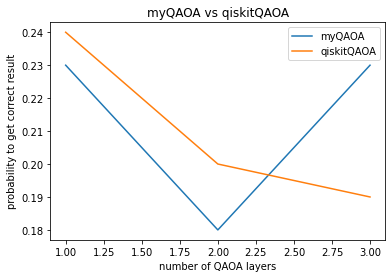

In [89]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()  # Create a figure and an axes.
x = range(1,4)
ax.plot(x, myqaoa_res, label='myQAOA')  # Plot some data on the axes.
ax.plot(x, qiskit_res, label='qiskitQAOA')  # Plot some data on the axes.

ax.set_xlabel('number of QAOA layers')  # Add an x-label to the axes.
ax.set_ylabel('probability to get correct result')  # Add a y-label to the axes.
ax.set_title("myQAOA vs qiskitQAOA")  # Add a title to the axes.
ax.legend()  # Add a legend.
